# 📊 Projeto ETL: Monitor de Juro Real Brasileiro

### 🎯 Objetivo
Este projeto consiste em um pipeline de **ETL (Extract, Transform, Load)** desenvolvido em Python para analisar a rentabilidade real da renda fixa no Brasil. O objetivo é responder à pergunta: *"O investimento na taxa Selic superou a inflação nos últimos 12 meses?"*

### ⚙️ Arquitetura do Pipeline
1.  **Extract:** Coleta automatizada de séries temporais (Selic e IPCA) diretamente da API de Dados Abertos do Banco Central do Brasil.
2.  **Transform:**
    * Limpeza e conversão de tipos de dados.
    * Unificação de bases (Merge) via data.
    * Aplicação da **Equação de Fisher** para cálculo do Juro Real.
    * Cálculo de janelas móveis (Rolling Windows) para análise acumulada de 12 meses.
3.  **Load:** Visualização gráfica dos ciclos econômicos e exportação dos dados tratados em CSV para BI.

---

### 1. Configuração do Ambiente
Nesta etapa, importamos as bibliotecas essenciais para o ciclo de vida do dado:
* **Pandas:** Para manipulação tabular e cálculos de janelas temporais.
* **Requests:** Para conexão HTTP com a API do governo.
* **Matplotlib/Seaborn:** Para a camada de visualização de dados.

In [24]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime

# Configuração de estilo visual
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


### 2. Extração de Dados (Extract)
Conectamos ao **SGS (Sistema Gerenciador de Séries Temporais)** do Banco Central. Criamos uma função modular para buscar qualquer série via JSON.

**Dados extraídos:**
* **Série 4390:** Taxa Selic acumulada no mês (Juro Nominal).
* **Série 433:** IPCA no mês (Índice de Inflação oficial).

In [25]:
def extrair_dados_bcb(codigo_serie):
    """
    Busca dados da API pública do Banco Central do Brasil.
    URL Base: http://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo}/dados?formato=json
    """
    url = f"http://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo_serie}/dados?formato=json"

    try:
        response = requests.get(url)
        response.raise_for_status() # Alerta se der erro 404 ou 500

        # Converte o JSON direto para DataFrame
        df = pd.DataFrame(response.json())

        # Tratamento inicial básico (Tipagem)
        df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y')
        df['valor'] = pd.to_numeric(df['valor'])

        return df.set_index('data')

    except Exception as e:
        print(f"Erro ao extrair série {codigo_serie}: {e}")
        return None

# Executando a Extração
print("Iniciando extração de dados...")
df_selic = extrair_dados_bcb(4390) # Selic Mensal
df_ipca = extrair_dados_bcb(433)   # IPCA Mensal

# Renomeando colunas para facilitar o merge
df_selic.columns = ['selic_mensal']
df_ipca.columns = ['ipca_mensal']

print("Extração concluída!")
print(f"Dados Selic: {len(df_selic)} linhas | Dados IPCA: {len(df_ipca)} linhas")

Iniciando extração de dados...
Extração concluída!
Dados Selic: 474 linhas | Dados IPCA: 551 linhas


### 3. Transformação e Engenharia de Dados (Transform)
Esta é a etapa crítica de regras de negócio. Realizamos três operações principais:

1.  **Sincronização:** Unimos as tabelas de Juros e Inflação baseado no índice temporal (`Merge`).
2.  **Cálculo Financeiro:** Aplicamos a **Equação de Fisher**.
    > *Nota Técnica:* Em finanças, não subtraímos a inflação dos juros (Selic - IPCA). A fórmula correta para o ganho real é: $$(1 + Selic) / (1 + IPCA) - 1$$
3.  **Janela Móvel (Rolling Window):** Calculamos o acumulado dos últimos 12 meses para cada ponto no tempo, eliminando a volatilidade mensal e permitindo uma análise de tendência anualizada.

In [26]:
# 1. Merge (Juntar Selic e IPCA nas datas coincidentes)
df_final = pd.merge(df_selic, df_ipca, left_index=True, right_index=True, how='inner')

# 2. Converter escala (Ex: 0.5% vira 0.005 para cálculo)
df_final['selic_dec'] = df_final['selic_mensal'] / 100
df_final['ipca_dec'] = df_final['ipca_mensal'] / 100

# 3. Cálculo do Juro Real Mensal (Equação de Fisher)
# Fórmula: (1 + Selic) / (1 + IPCA) - 1
df_final['juro_real_mensal'] = ((1 + df_final['selic_dec']) / (1 + df_final['ipca_dec'])) - 1

# 4. Cálculo Acumulado de 12 meses (Janela Móvel)
# Explicação: Para acumular juros compostos, usamos (1+i) * (1+i)...
# A função rolling(12) pega os últimos 12 meses.
def acumular_juros(x):
    return (x + 1).prod() - 1

# Aplicando a janela móvel de 12 meses
df_final['selic_12m'] = df_final['selic_dec'].rolling(12).apply(acumular_juros)
df_final['ipca_12m'] = df_final['ipca_dec'].rolling(12).apply(acumular_juros)
df_final['juro_real_12m'] = df_final['juro_real_mensal'].rolling(12).apply(acumular_juros)

# Removendo os primeiros 11 meses que ficaram vazios (NaN) devido ao cálculo da janela
df_final.dropna(inplace=True)

# Voltando para porcentagem para ficar legível (0.10 -> 10.0)
cols_visualizacao = ['selic_12m', 'ipca_12m', 'juro_real_12m']
df_final[cols_visualizacao] = df_final[cols_visualizacao] * 100

print("Transformação concluída. Amostra dos dados:")
display(df_final[['selic_12m', 'ipca_12m', 'juro_real_12m']].tail())

Transformação concluída. Amostra dos dados:


,selic_12m,ipca_12m,juro_real_12m
data,,,
2025-08-01,12.893471,5.130501,7.384128
2025-09-01,13.318893,5.172369,7.745879
2025-10-01,13.711854,4.680811,8.627219
2025-11-01,14.005188,4.461836,9.135731
2025-12-01,14.332756,4.264385,9.656578


### 4. Visualização Analítica (Load - Viz)
Geramos um gráfico para identificar os ciclos econômicos.
* **Linha Verde:** Representa o ganho real (poder de compra aumentado).
* **Área Vermelha:** Destaca períodos onde a inflação superou o rendimento da Selic (perda de poder de compra).

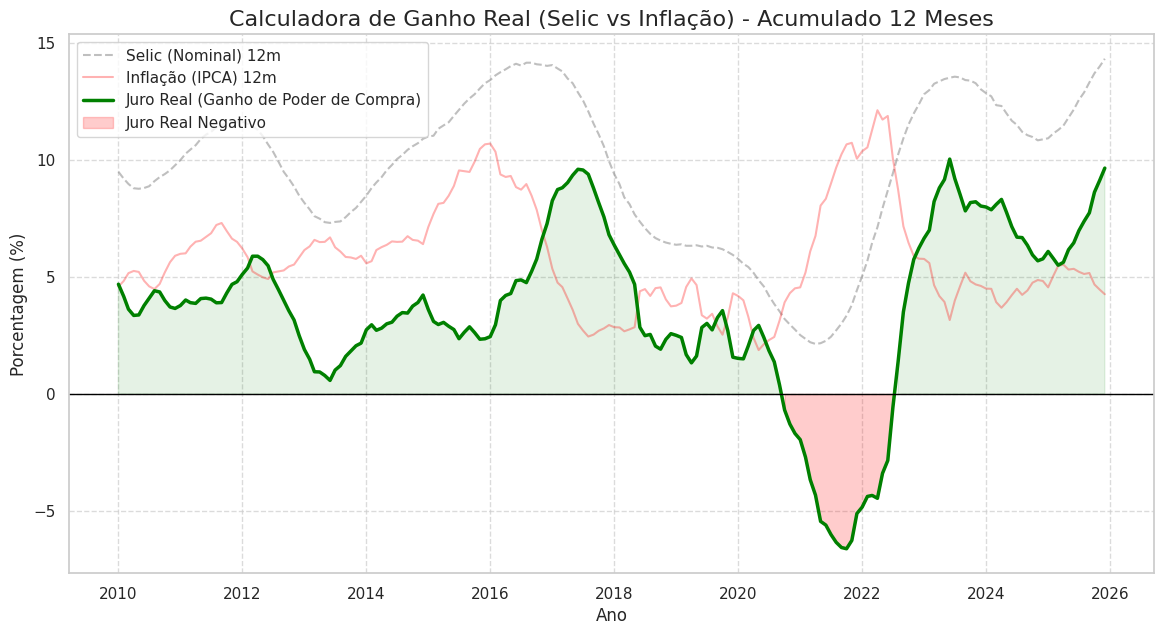

In [27]:
# Filtrar dados a partir de 2010
df_plot = df_final[df_final.index >= '2010-01-01']

plt.figure(figsize=(14, 7))

# Plotando as linhas
plt.plot(df_plot.index, df_plot['selic_12m'], label='Selic (Nominal) 12m', color='gray', alpha=0.5, linestyle='--')
plt.plot(df_plot.index, df_plot['ipca_12m'], label='Inflação (IPCA) 12m', color='red', alpha=0.3)
plt.plot(df_plot.index, df_plot['juro_real_12m'], label='Juro Real (Ganho de Poder de Compra)', color='green', linewidth=2.5)

# Adicionando linha zero
plt.axhline(0, color='black', linewidth=1)

# Preenchendo área onde Juro Real é negativo (Perda de dinheiro)
plt.fill_between(df_plot.index, df_plot['juro_real_12m'], 0,
                 where=(df_plot['juro_real_12m'] < 0),
                 color='red', alpha=0.2, label='Juro Real Negativo')

# Preenchendo área onde Juro Real é positivo (Ganho real)
plt.fill_between(df_plot.index, df_plot['juro_real_12m'], 0,
                 where=(df_plot['juro_real_12m'] > 0),
                 color='green', alpha=0.1)

plt.title('Calculadora de Ganho Real (Selic vs Inflação) - Acumulado 12 Meses', fontsize=16)
plt.ylabel('Porcentagem (%)')
plt.xlabel('Ano')
plt.legend(loc='upper left')
plt.grid(True, which='major', linestyle='--', alpha=0.7)

plt.show()

### 5. Exportação dos Dados (Load - Data)
Por fim, materializamos o DataFrame processado em um arquivo `.csv` estruturado. Este arquivo serve como insumo final, pronto para ser consumido por ferramentas de Dashboard (como Power BI ou Tableau) ou para arquivamento histórico.

In [28]:
# Selecionando colunas relevantes para o usuário final
colunas_finais = ['selic_12m', 'ipca_12m', 'juro_real_12m']
df_export = df_final[colunas_finais].round(2)

# Salvando em CSV
nome_arquivo = 'relatorio_juro_real_brasil.csv'
df_export.to_csv(nome_arquivo, sep=';', encoding='utf-8-sig')

print(f"Arquivo '{nome_arquivo}' gerado com sucesso!")

Arquivo 'relatorio_juro_real_brasil.csv' gerado com sucesso!
